In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from matplotlib import pyplot as plt
import random
from PIL import Image
import math
import itertools
from plotly.graph_objects import treemap
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.subplots as sp
import gc
from collections import Counter
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.subplots as sp

def count_items(series):
    return len(series[~series.isna()])

def show_clear_plt():
    plt.tight_layout()
    plt.show()
    plt.clf()


sns.set(font_scale=1.5)
sns.set_style(style='darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['legend.facecolor'] = 'white'

def reduce_memory_usage(df, columns, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

Some plots of which types of items / colours are popular depending on the time of year.

Not sure how useful this is just found it interesting to explore briefly. We can see how some types of clothing or some colours are much more popular at certain times of year.

I haven't read all the EDA notebooks for this comp so apologies to anyone in advance who has already done this in a public notebook...

# Setup

In [ ]:
class CONFIG:
    KAGGLE = os.path.exists('../input/h-and-m-personalized-fashion-recommendations/')

    if KAGGLE:
        PATH = '../input/h-and-m-personalized-fashion-recommendations/'
        print('running on Kaggle')
    else:
        PATH = 'NA'
        print('not running on Kaggle')

    DEBUG = False
    DEBUG_PC = 0.1

    print(f'debugging / reduce data rows is {DEBUG}')

    EXAMPLE_LIMIT = 10

In [ ]:
transactions = pd.read_parquet('../input/h-m-save-to-parquet/transactions_train.parquet',
                     )
customers = pd.read_parquet('../input/h-m-save-to-parquet/customers.parquet')
articles = pd.read_parquet('../input/h-m-save-to-parquet/articles.parquet',
                      )

print(transactions.dtypes)

# Data subsampling

(this reduces data size if DEBUG selected in CONFIG)

In [ ]:
if CONFIG.DEBUG:
    random.seed(42)

    # subsample the articles
    unique_articles = articles['article_id'].unique().tolist()
    sample_articles = random.sample(unique_articles, int(CONFIG.DEBUG_PC * len(unique_articles)))
    print(f'number of sample articles {len(sample_articles)}')

    print(articles.shape)
    articles = articles[articles['article_id'].isin(sample_articles)].reset_index(drop=True)
    print(articles.shape)

    # subsample the customers
    unique_customers = customers['customer_id'].unique().tolist()
    sample_customers = random.sample(unique_customers, int(CONFIG.DEBUG_PC * len(unique_customers)))
    print(f'number of sample customers {len(sample_customers)}')

    print(customers.shape)
    customers = customers[customers['customer_id'].isin(sample_customers)].reset_index(drop=True)
    print(customers.shape)

    print(f'original train transactions shape {transactions.shape}')
    transactions = transactions[(transactions['customer_id'].isin(sample_customers)) &
                                (transactions['article_id'].isin(sample_articles))].reset_index(drop=True)

    print(f'reduced train transactions shape {transactions.shape}')
    
else:
    print('running with all train data')

# Check seasonality of product groups, colours

Step 1 - use cyclic encoding on dates

In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from matplotlib import pyplot as plt
import random
from PIL import Image
import math
import itertools
from plotly.graph_objects import treemap
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.subplots as sp
import gc
from collections import Counter
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.subplots as sp

In [8]:
def show_clear_plt():
    plt.tight_layout()
    plt.show()
    plt.clf()

In [13]:
def count_items(series):
    return len(series[~series.isna()])

In [5]:
articles = pd.read_csv("data/articles.csv")
customers = pd.read_csv("data/customers.csv")
transactions = pd.read_csv("data/transactions_train.csv")

NameError: name 'show_clear_plt' is not defined

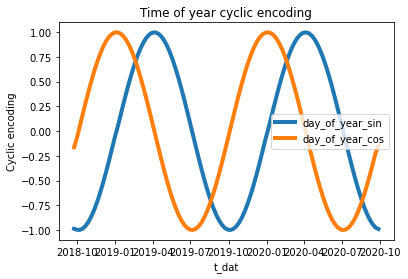

In [7]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['day_of_year'] = transactions['t_dat'].dt.dayofyear
transactions['week'] = transactions['t_dat'].dt.isocalendar().week
transactions['quarter'] = transactions['t_dat'].dt.quarter
transactions['month'] = transactions['t_dat'].dt.month

def cyclic_encode(df, column):
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / df[column].max())
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / df[column].max())
    return df


encode_cols = [
    'day_of_year',
]

for ec in encode_cols:
    transactions[ec] = transactions[ec] - transactions[ec].min()
    transactions = cyclic_encode(transactions, ec)

# display example

cyclic_outputs = ['day_of_year_sin', 'day_of_year_cos']

daily_transactions = transactions.groupby(['t_dat'])[cyclic_outputs].mean()

for c in daily_transactions.columns:
    sns.lineplot(x=daily_transactions[c].resample('w').mean().index,
                 y=daily_transactions[c].resample('w').mean().values,
                 linewidth=4)
plt.title('Time of year cyclic encoding')
plt.legend(daily_transactions.columns.tolist())
plt.ylabel('Cyclic encoding')
show_clear_plt()

Below demonstrates the position of months 1-12 in the cycle

Winter (for northern hemisphere - which looks to be the location of this data) is in the upper part of the outputs.

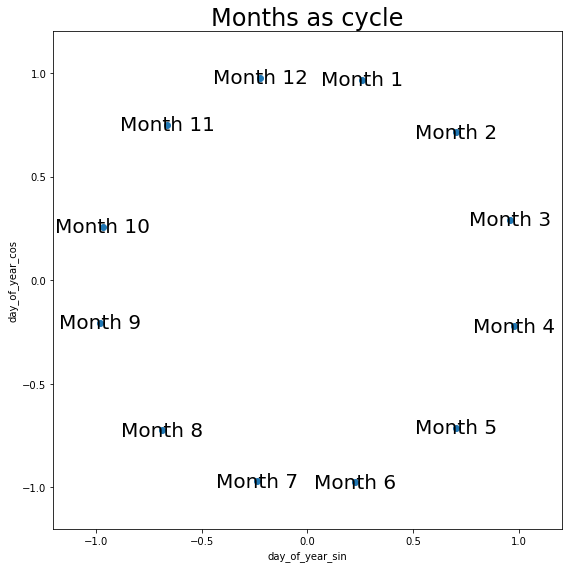

<Figure size 432x288 with 0 Axes>

In [9]:
qs = transactions.groupby(['month'])[cyclic_outputs].median()
fig, axes = plt.subplots(figsize=(8, 8))
plt.scatter(x=qs[cyclic_outputs[0]],
            y=qs[cyclic_outputs[1]])

for i in qs.index:
    plt.annotate(f'Month {i}', (qs.loc[i, cyclic_outputs[0]],
                     qs.loc[i, cyclic_outputs[1]]),
                 ha='center',
                 va='center',
                 fontsize=20)
plt.xlabel(cyclic_outputs[0])
plt.ylabel(cyclic_outputs[1])
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.title('Months as cycle',
          fontsize=24)
show_clear_plt()

In [ ]:
def plot_category_seasonality(column, n_examples=5):

    transactions[column] = transactions['article_id'].map(dict(zip(articles['article_id'],
                                                               articles[column])))

    feature_dict = {cyclic_outputs[0]: [np.mean],
                    cyclic_outputs[1]: [np.mean],
                    'article_id': [count_items],}

    top_examples = transactions[column].value_counts().sort_values(ascending=False).index[:n_examples].tolist()

    cat_seasonality = transactions[transactions[column].isin(top_examples)].groupby([column]).agg(feature_dict)
    cat_seasonality.columns = [f'{a}_{b}' for a,b in cat_seasonality.columns]

    fig = px.scatter(cat_seasonality, x=cat_seasonality[f'{cyclic_outputs[0]}_mean'],
                     y=cat_seasonality[f'{cyclic_outputs[1]}_mean'],
                     size=cat_seasonality['article_id_count_items'],
                      color=cat_seasonality[f'{cyclic_outputs[1]}_mean'],
                     text=cat_seasonality.index,
                     log_x=False,
                     size_max=150,
                     color_continuous_scale='solar_r',
                     )

    fig.update_layout(
        title=dict(text=f'<b>Examples for category {column} weighted by time of year (as cycle)<b>',
                   font=dict(
                       family="Arial",
                       size=20,
                       color='#000000'
                   )),

        xaxis_title="Autumn (left) to Spring (right)",
        yaxis_title="Summer (lower) to Winter (upper)",
        height=600,
        width=900,
        font=dict(
            family="Arial",
            size=18,
            color='#000000'
        )
    )

    fig.show()

In [12]:
column = 'product_type_name' 
n_examples=5
transactions[column] = transactions['article_id'].map(dict(zip(articles['article_id'],
                                                               articles[column])))

In [23]:
top_examples = transactions[column].value_counts().sort_values(ascending=False).index[:n_examples].tolist()

In [24]:
top_examples

['Trousers', 'Dress', 'Sweater', 'T-shirt', 'Top']

In [17]:
transactions[column]

0           Underwear body
1                      Bra
2                  Sweater
3                  Sweater
4                  Sweater
                 ...      
31788319             Dress
31788320           Unknown
31788321               Bag
31788322              Ring
31788323            Blouse
Name: product_type_name, Length: 31788324, dtype: object

In [14]:
feature_dict = {cyclic_outputs[0]: [np.mean],
                cyclic_outputs[1]: [np.mean],
                'article_id': [count_items],}

In [20]:
top_examples = transactions[column].value_counts().sort_values(ascending=False).index[:n_examples].tolist()

cat_seasonality = transactions[transactions[column].isin(top_examples)].groupby([column]).agg(feature_dict)


In [22]:
cat_seasonality.columns = [f'{a}_{b}' for a,b in cat_seasonality.columns]
cat_seasonality

,day_of_year_sin_mean,day_of_year_cos_mean,article_id_count_items
product_type_name,,,
Dress,0.073486,-0.238472,3238428
Sweater,-0.303823,0.330076,2783274
T-shirt,0.103321,-0.204384,2203750
Top,0.003412,-0.084326,1583408
Trousers,-0.016042,0.014318,4217017


In [ ]:
plot_category_seasonality('product_type_name', n_examples=CONFIG.EXAMPLE_LIMIT)

In [ ]:
plot_category_seasonality('product_group_name', n_examples=CONFIG.EXAMPLE_LIMIT)

In [ ]:
plot_category_seasonality('index_group_name', n_examples=CONFIG.EXAMPLE_LIMIT)

In [ ]:
plot_category_seasonality('garment_group_name', n_examples=CONFIG.EXAMPLE_LIMIT)

In [ ]:
plot_category_seasonality('index_name', n_examples=CONFIG.EXAMPLE_LIMIT)

In [ ]:
plot_category_seasonality('colour_group_name', n_examples=CONFIG.EXAMPLE_LIMIT)

In [ ]:
plot_category_seasonality('perceived_colour_value_name', n_examples=CONFIG.EXAMPLE_LIMIT)